# Visualize seasonal change in the FSD

Selecting images from 2014 to show variation



In [6]:
import os
import rasterio as rio
from rasterio.plot import reshape_as_image
import pandas as pd
import numpy as np

plot_images = [
'20140415.terra.truecolor.250m',
'20140427.aqua.truecolor.250m',
'20140508.terra.truecolor.250m',
'20140520.terra.truecolor.250m',
'20140610.aqua.truecolor.250m',
'20140712.aqua.truecolor.250m',
'20140721.terra.truecolor.250m',
'20140803.aqua.truecolor.250m']

In [2]:

dataloc = "/Volumes/Research/ENG_Wilhelmus_Shared/group/IFT_fram_strait_dataset/"

tc_images = {}
matlab_floe_images = {}
clean_floe_images = {}

def get_month_folder(date):
    """Simple utility for navigating file structure"""
    start = '{y}{m}01'.format(y=date.year,
                              m=str(date.month).zfill(2))
    end = '{y}{m}01'.format(y=date.year,
                              m=str(date.month + 1).zfill(2))
    if (date.month == 3) | (date.month == 4):
        start = '{y}0331'.format(y=date.year)
        end = '{y}0501'.format(y=date.year)
    
    return '-'.join(['fram_strait', start, end])
    
for imstring in plot_images:
    date = pd.to_datetime(imstring.split('.')[0])
    satellite = imstring.split('.')[1]
    tc_images[date] = rio.open(dataloc + 'fram_strait-{y}/{m}/truecolor/{d}.{s}.truecolor.250m.tiff'.format(
        d=date.strftime('%Y%m%d'), s=satellite, y=date.year, m=get_month_folder(date))).read()
    matlab_floe_images[date] = rio.open(dataloc + 'fram_strait-{y}/{m}/labeled_raw/{d}.{s}.labeled_raw.250m.tiff'.format(
        d=date.strftime('%Y%m%d'), s=satellite, y=date.year, m=get_month_folder(date))).read()
    clean_floe_images[date] = rio.open(dataloc + 'fram_strait-{y}/{m}/labeled_clean/{d}.{s}.labeled_clean.250m.tiff'.format(
        d=date.strftime('%Y%m%d'), s=satellite, y=date.year, m=get_month_folder(date))).read()


# Plotting by size bin



In [9]:
bins = [0, 50, 100, 150, 250, 500] # km2

In [3]:
floe_lib_clean = {}
for file in os.listdir('../data/floe_tracker/ift_floe_property_tables/clean/'):
    if 'csv' in file: 
        year = int(file.replace('.csv', '').split('_')[-1])
        floe_lib_clean[year] = pd.read_csv('../data/floe_tracker/ift_floe_property_tables/clean/' + file,
                                         index_col=0, dtype={'classification': str})
        floe_lib_clean[year]['datetime'] = pd.to_datetime(floe_lib_clean[year]['datetime'])
floe_lib_clean = pd.concat(floe_lib_clean).reset_index()

In [7]:
floe_lib_clean['area_adj_km2'] = (np.sqrt(floe_lib_clean.area) + 8)**2*.25*.25 
floe_lib_clean.columns

Index(['level_0', 'level_1', 'datetime', 'satellite', 'floe_id', 'label',
       'longitude', 'latitude', 'x_stere', 'y_stere', 'col_pixel', 'row_pixel',
       'area', 'perimeter', 'solidity', 'orientation', 'circularity',
       'axis_major_length', 'axis_minor_length', 'bbox_min_row',
       'bbox_min_col', 'bbox_max_row', 'bbox_max_col', 'area_matlab',
       'perimeter_matlab', 'solidity_matlab', 'orientation_matlab',
       'nsidc_sic', 'theta_aqua', 'theta_terra', 'tc_channel0', 'tc_channel1',
       'tc_channel2', 'fc_channel0', 'fc_channel1', 'fc_channel2',
       'init_classification', 'lr_probability', 'lr_classification',
       'final_classification', 'area_adj_km2'],
      dtype='object')

In [10]:
floe_lib_clean['area_bin'] = np.digitize(floe_lib_clean['area_adj_km2'], bins)

In [13]:
date = pd.to_datetime('2014-04-15')

In [15]:
df_date = floe_lib_clean.loc[floe_lib_clean.datetime.dt.date == date.date()]

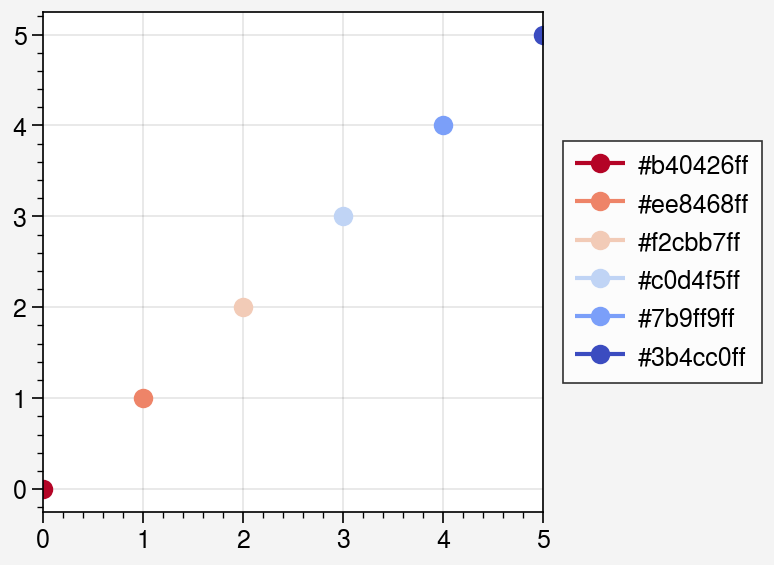

In [21]:
import ultraplot as pplt
colors = [c['color'] for c in pplt.Cycle('coolwarm_r', len(bins))]
bin_colors = {idx: c for idx, c in zip(bins, colors)}
fig, ax = pplt.subplots()
for idx, c in enumerate(colors):
    ax.plot(idx, idx, color=c, marker='o', label=c)
ax.legend(ncols=1, loc='r')

In [108]:
binned_floe_images = {}
for date in clean_floe_images:
    df_date = floe_lib_clean.loc[floe_lib_clean.datetime.dt.date == date.date()]
    df_date = floe_lib_clean.loc[floe_lib_clean.datetime.dt.date == date.date()]
    img = np.zeros(clean_floe_images[date].shape)
    for idx, row in df_date.iterrows():
        img[clean_floe_images[date] == row.label] = row.area_bin
    binned_floe_images[date] = img

In [78]:
df_date.loc[df_date.area_bin == 3]

,level_0,level_1,datetime,satellite,floe_id,label,longitude,latitude,x_stere,y_stere,...,tc_channel2,fc_channel0,fc_channel1,fc_channel2,init_classification,lr_probability,lr_classification,final_classification,area_adj_km2,area_bin
457572,2014,91343,2014-08-03 12:26:09,aqua,unmatched,142,1.5301,79.8037,803638.8,-761822.6,...,196.2,4.6,187.8,208.3,UK,0.806,True,True,101.872828,3
457576,2014,91361,2014-08-03 12:26:09,aqua,unmatched,162,-0.3814,79.0219,837753.8,-848982.1,...,188.3,7.4,175.5,197.4,UK,0.572,True,True,105.683490,3
457590,2014,91456,2014-08-03 12:26:09,aqua,unmatched,48,-5.1608,80.8672,635089.2,-761197.9,...,196.3,9.4,188.7,208.9,UK,0.815,True,True,102.262461,3
457604,2014,91495,2014-08-03 12:26:09,aqua,unmatched,28,-16.6220,79.1619,559617.2,-1035941.5,...,197.6,23.0,188.8,208.1,UK,0.749,True,True,115.639283,3
457617,2014,91520,2014-08-03 12:26:09,aqua,unmatched,113,-9.1334,78.1019,757773.9,-1048109.3,...,205.1,3.6,198.0,217.3,UK,0.981,True,True,137.309083,3
457619,2014,91525,2014-08-03 12:26:09,aqua,unmatched,118,-5.3282,78.9956,763264.4,-920278.6,...,199.8,3.1,187.1,210.4,UK,0.906,True,True,134.593229,3
457624,2014,91537,2014-08-03 12:26:09,aqua,unmatched,131,-3.3366,79.1248,785399.3,-882646.7,...,195.9,5.3,182.8,206.3,UK,0.709,True,True,102.340366,3


In [88]:
row = df_date
row.label, row.area, np.mean(img[clean_floe_images[date] == row.label])

(93, 2042.0, np.float64(2042.0))

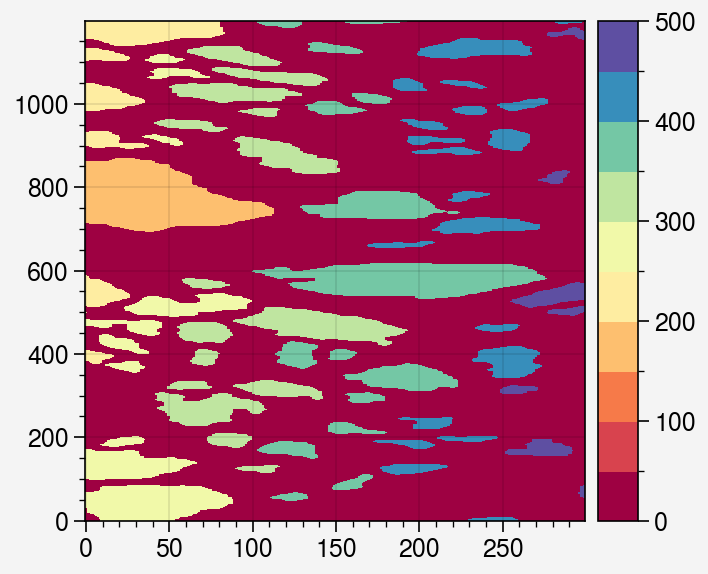

In [97]:
fig, ax = pplt.subplots()
ax.pcolormesh(clean_floe_images[date][0, 1900:3100, 2200:2500], cmap='spectral', colorbar=True)

In [103]:
np.unique(clean_floe_images[date])

array([  0,   1,   2,   3,   4,   5,   6,   8,   9,  10,  12,  14,  25,
        27,  29,  30,  32,  33,  34,  35,  37,  38,  40,  42,  43,  44,
        45,  46,  47,  48,  49,  52,  53,  54,  58,  59,  61,  62,  63,
        64,  66,  69,  70,  72,  74,  75,  77,  78,  79,  80,  81,  83,
        84,  85,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177,
       178, 179, 180, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 198, 199, 200, 201, 202, 204, 205, 206, 207,
       208, 211, 212, 213, 214, 215, 216, 218, 219, 220, 221, 22

In [105]:
df_date = floe_lib_clean.loc[floe_lib_clean.datetime.dt.date == date.date()]
np.unique(df_date.label)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  18,  21,  23,  24,  25,  27,  29,  30,  31,  32,
        33,  34,  35,  37,  38,  40,  42,  43,  44,  45,  46,  47,  48,
        49,  52,  53,  54,  56,  58,  59,  60,  61,  62,  63,  64,  66,
        68,  69,  70,  71,  72,  73,  74,  75,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 19

In [38]:
bin_labels = {
 50: '50-100 km$^2$',
 100: '100-150 km$^2$',
 150: '150-250 km$^2$',
 250: '250-500 km$^2$',
 500: '500+ km$^2$'}

In [109]:
for date in clean_floe_images:
    img = binned_floe_images[date]
    fig, ax = pplt.subplots()
    for idx, bn in enumerate(bin_colors):
        if bn != 0:
            ax.imshow(np.ma.masked_array(img, img != idx).squeeze()[0:4000, 1000:3000], color=bin_colors[bn])
    for bn in bin_labels:
        ax.plot([], [], lw=0, marker='s', color=bin_colors[bn], label=bin_labels[bn])
    ax.format(xticks=False, yticks=False, grid=False, ylabel='', xlabel='', title=date.strftime('%Y-%m-%d'))
    ax.legend(ncols=1, loc='ll')
    fig.save('../figures/animations/fsd_visualizer_' + date.strftime('%Y-%m-%d') + '.jpg', dpi=300)
    pplt.close(fig)

In [44]:
date = pd.to_datetime('2014-04-27')
img = binned_floe_images[date]

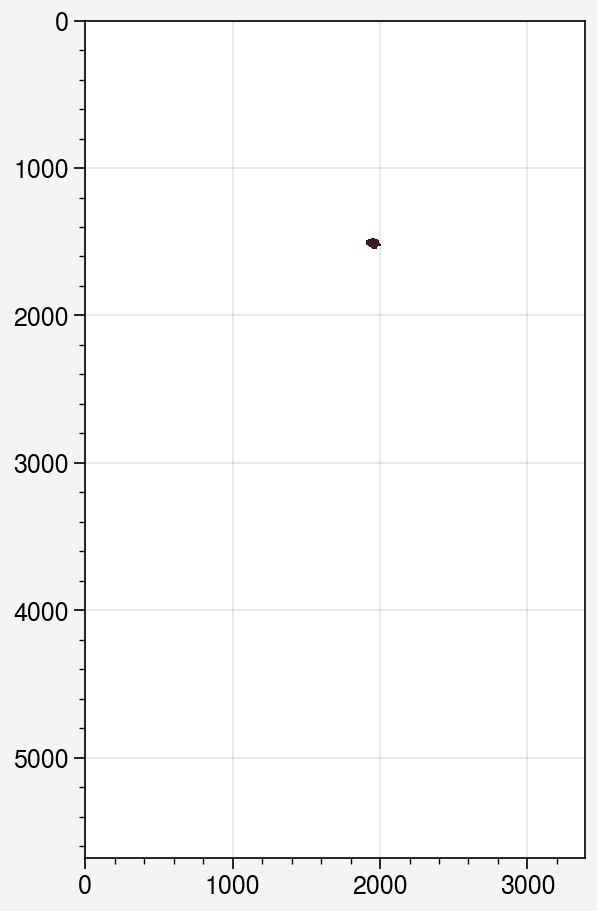

In [66]:
fig, ax = pplt.subplots()
ax.imshow(np.ma.masked_array((clean_floe_images[date].squeeze() == 95).astype(int)))